# Sound-evoked neural responses during oddball paradigm

Here we will evaluate the responses of neurons to sound stimuli, by extracting a window of the fluorescence signal around the time of each stimulus.</br>
**Note:** This notebook requires that you have generated the `soundID.npz` file (as described in the notebook `oddball_fm_sound_identity.ipynb`)

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

First, a function we will need to extract windows around each stimulus onset.

In [60]:
def lock_to_event(signal, srate, eventOnsetTime, timeRange):
    """
    Extracts a window of signal around each event.

    Args:
        signal (numpy.ndarray): The input signal.
        srate (float): The sampling rate of the signal.
        eventOnsetTime (numpy.ndarray): Array of event onset times (in seconds).
        timeRange (tuple): Time window (start, end) to extract around the event.

    Returns:
        numpy.ndarray: 2D array where each row corresponds to a trial,
            and each column corresponds to a sample within the specified time range.
        numpy.ndarray: Time vector corresponding to the columns in the locked signal.

    Note:
        If there are not enough samples to extract within the specified time range for an event,
        the corresponding row in the locked signal array will be filled with NaN values.
    """
    samplesVec = np.arange(int(timeRange[0]*srate),
                           int(timeRange[-1]*srate))
    timeVec = samplesVec/srate
    nSamples = len(timeVec)
    nTrials = len(eventOnsetTime)
    eventOnsetSamples = np.round(eventOnsetTime*srate).astype(int)
    lockedSignal = np.empty((nTrials, nSamples))
    for inde, eventSample in enumerate(eventOnsetSamples):
        try:
            lockedSignal[inde,:] = signal[samplesVec+eventSample]
        except IndexError:
            # Do this if there are not enough samples to get will window
            lockedSignal[inde,:] = np.full(nSamples, np.nan)
    return (lockedSignal, timeVec)


## Load the calcium imaging data.

In [61]:
dataPath = '/data/mesoscope/6998_231122_E295/fm_3_pre_doi/'
suite2pPath = 'suite2p_out/plane4/'  # Plane4 is the AC plane

ops = np.load(os.path.join(dataPath, suite2pPath, 'ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(dataPath, suite2pPath, 'iscell.npy'), allow_pickle=True)
rawF = np.load(os.path.join(dataPath, suite2pPath, 'F.npy'), allow_pickle=True)
srate2p = ops['fs']  # Sampling rate: 11.16 frames/s

Let's calculate the dF/F keeping only the good cells (according to Suite2p):

In [62]:
meanF = rawF.mean(axis=1)
dFoverF = (rawF-meanF[:,np.newaxis])/meanF[:,np.newaxis]
iscellBool = (iscell[:,0] == 1) & (iscell[:,1] > 0.50)
dFoverF = dFoverF[iscellBool]

Let's plot the neural data:

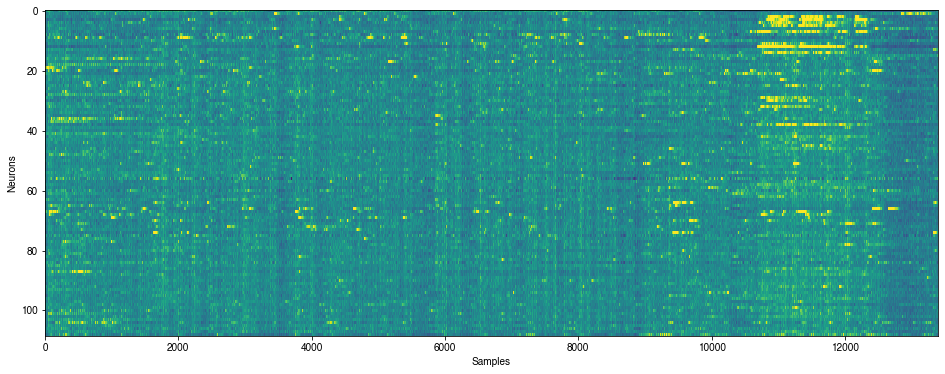

In [63]:
plt.figure(figsize=(16,6))
plt.imshow(dFoverF, interpolation='nearest', aspect='auto', vmax=1, vmin=-1)
plt.xlabel('Samples')
plt.ylabel('Neurons');

## Load the sound timing and identity

In [64]:
srateSound = 50000  # According to Evan
soundID = np.load(os.path.join(dataPath, 'soundID.npz'), allow_pickle=True)
soundOnsetInSamples = soundID['onsetInds']
sweepDirection = soundID['sweepDirection']
sweepDirectionLabels = soundID['sweepDirectionLabels'].item()

Let's verify that the duration of the imaging data matches that of the sound onsets:

In [65]:
sessionDuration = dFoverF.shape[1]/srate2p  # In seconds
soundOnset = soundOnsetInSamples/srateSound # In seconds
print(f'Imaging session: {sessionDuration/60:0.2f} min')
print(f'Last sound onset: {soundOnset[-1]/60:0.2f} min')

Imaging session: 20.00 min
Last sound onset: 21.11 min


Note that the last sound onset seems to happen later than the length of the session. We'll check later if this is a problem.

## Let's align the neural data to the sound events

Let's start by averaging the activity of all neurons and extract a window of activity around each stimulus.

In [66]:
timeRange = [-3, 6]  # A wide window to encompass more that one event
meandFF = dFoverF.mean(axis=0)
lockedSignal, timeVec = lock_to_event(meandFF, srate2p, soundOnset, timeRange)

Let's plot the neural data, aligned to the time of sound events:

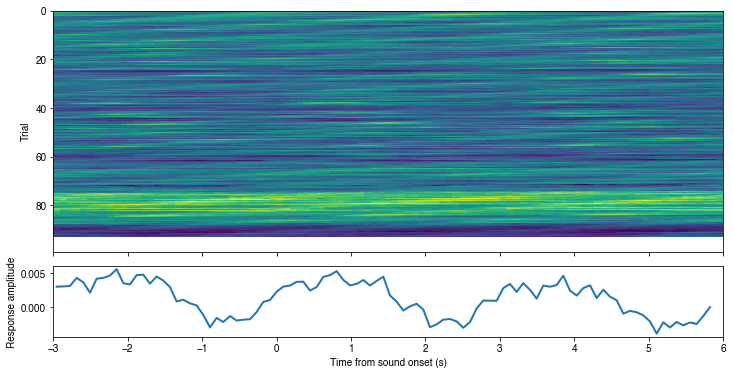

In [67]:
plt.figure(figsize=(12,6))
ax0 = plt.subplot(4, 1, (1,3))
plt.imshow(lockedSignal, interpolation='nearest', extent=[*timeRange, lockedSignal.shape[1], 0])
plt.ylabel('Trial')
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(4, 1, 4, sharex=ax0)
plt.plot(timeVec, np.nanmean(lockedSignal, axis=0), lw=2)
plt.xlabel('Time from sound onset (s)')
plt.ylabel('Response amplitude');

That looks a little suspiciously misaligned. Let's zoom in:

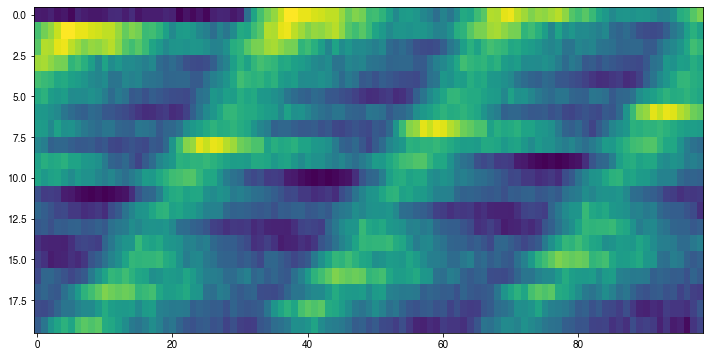

In [68]:
plt.figure(figsize=(12,6))
plt.imshow(lockedSignal[:20,:], interpolation='nearest');

## The sampling rate of sounds seems wrong, let's try a different one:

In [69]:
srateSound = 52470  # Instead of the original 50000. Made up by Santiago to get aligned data.
soundOnset = soundOnsetInSamples/srateSound # In seconds
print(f'Imaging session: {sessionDuration/60:0.2f} min')
print(f'Last sound onset: {soundOnset[-1]/60:0.2f} min')

Imaging session: 20.00 min
Last sound onset: 20.11 min


Let's aligned the data and plot it with this new sampling rate:

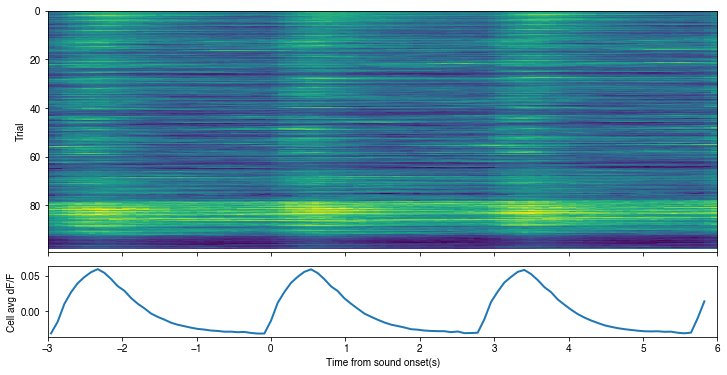

In [95]:
lockedSignal, timeVec = lock_to_event(meandFF, srate2p, soundOnset, timeRange)

plt.figure(figsize=(12,6))
ax0 = plt.subplot(4, 1, (1,3))
plt.imshow(lockedSignal, interpolation='nearest', extent=[*timeRange, lockedSignal.shape[1], 0])
plt.ylabel('Trial')
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(4, 1, 4, sharex=ax0)
plt.plot(timeVec, np.nanmean(lockedSignal, axis=0), lw=2)
plt.xlabel('Time from sound onset(s)')
plt.ylabel('Cell avg dF/F');

Let's plot a few of individual cells:

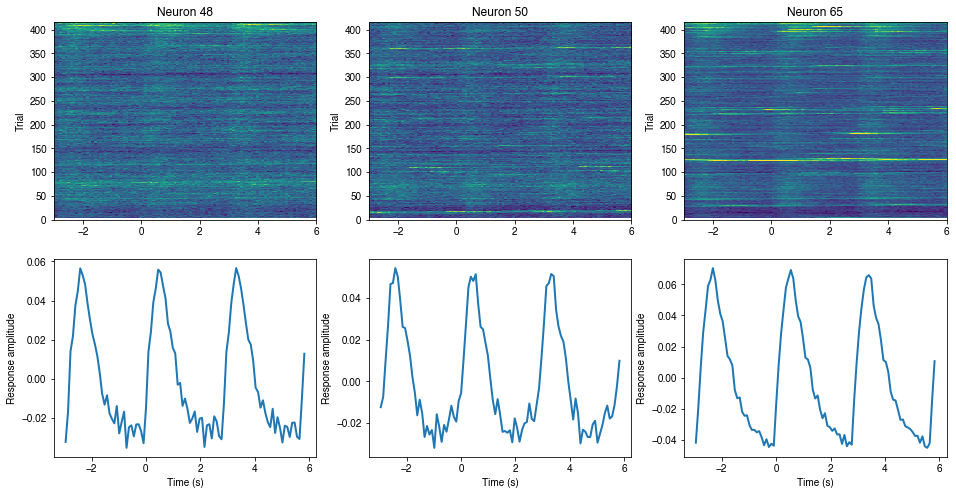

In [75]:
neuronsToPlot = [48, 50, 65]

plt.figure(figsize=(16,8))
for indn, neuronInd in enumerate(neuronsToPlot):
    lockedSignal, timeVec = lock_to_event(dFoverF[neuronInd,:], srate2p, soundOnset, timeRange)
    plt.subplot(2, len(neuronsToPlot), indn+1)
    plt.imshow(lockedSignal, vmax=1, interpolation='nearest', extent=[*timeRange, 0, nTrials])
    #plt.xlabel('Time (s)')
    plt.ylabel('Trial')
    plt.title('Neuron {}'.format(neuronInd))
    
    plt.subplot(2, len(neuronsToPlot), indn+1+len(neuronsToPlot))
    plt.plot(timeVec, np.nanmean(lockedSignal, axis=0), lw=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Response amplitude')

## Let's separate responses to oddball and standard sounds

Let's extract the soundOnsets only for the session with up-sweep oddballs:

In [90]:
lastSampleSubset = np.argmax(np.diff(soundOnset))  # The sample at which the time between stimuli is largest

In [91]:
soundOnsetSubset = soundOnset[:lastSampleSubset+1]
sweepDirectionSubset = sweepDirection[:lastSampleSubset+1]
upOnset = soundOnsetSubset[sweepDirectionSubset==sweepDirectionLabels['up']]
downOnset = soundOnsetSubset[sweepDirectionSubset==sweepDirectionLabels['down']]

We will finish this later. Evan fou